In [1]:
import numpy as np
from scipy.optimize import minimize

# PDF multivariada
def pdfnvar(x, m, K, n=2):
    x = np.asarray(x).reshape(-1)
    m = np.asarray(m).reshape(-1)
    diff = x - m
    exponent = -0.5 * np.dot(diff.T, np.linalg.solve(K, diff))
    denominator = np.sqrt((2 * np.pi) ** n * np.linalg.det(K))
    return (1 / denominator) * np.exp(exponent)

def project_data(X_source, X_ref, y_ref, k_proj, h_proj):
    dist = np.sum((X_source[:, None, :] - X_ref[None, :, :])**2, axis=2)
    k_proj = min(k_proj, X_ref.shape[0])
    idx = np.argsort(dist, axis=1)[:, :k_proj]
    n_features = X_ref.shape[1]
    K_mat = h_proj * np.eye(n_features)
    proj = []
    for i, indices_for_xt in enumerate(idx):
        xt = X_source[i]
        sum_pos = sum(pdfnvar(X_ref[j], xt, K_mat, n_features) for j in indices_for_xt if y_ref[j] == 1)
        sum_neg = sum(pdfnvar(X_ref[j], xt, K_mat, n_features) for j in indices_for_xt if y_ref[j] == -1)
        proj.append([sum_pos, sum_neg])
    return np.array(proj)

# Distância entre centróides no espaço Q1, Q2
def centroid_distance(X, y, k, h):
    X_pos = X[y == 1]
    X_neg = X[y == -1]

    if X_pos.shape[0] == 0 or X_neg.shape[0] == 0:
        return np.inf

    proj_pos = project_data(X_pos, X, y, k, h)
    proj_neg = project_data(X_neg, X, y, k, h)

    if proj_pos.size == 0 or proj_neg.size == 0:
        return np.inf

    c1 = proj_pos.mean(axis=0)
    c2 = proj_neg.mean(axis=0)
    return np.linalg.norm(c1 - c2)

# Otimiza k e h para minimizar distância entre centróides
def optimize_centroid_distance(X, y):
    def objective(params):
        k = int(np.clip(round(params[0]), 1, 400))
        h = 10 ** np.clip(params[1], -5, 2)
        return centroid_distance(X, y, k, h)

    result = minimize(objective, x0=[10, -1], bounds=[(1, 200), (-5, 1)], method='L-BFGS-B')
    best_k = int(round(result.x[0]))
    best_h = 10 ** result.x[1]
    return best_k, best_h

from sklearn.model_selection import train_test_split



----

## Importação de dados

In [3]:
import pandas as pd
from scipy.io import arff
from sklearn.preprocessing import StandardScaler
import numpy as np

datasets = {}

dataset_name_adult = 'adult_income'
data_path_adult_train = 'data/artigo2/adult/adult.data'
data_path_adult_test = 'data/artigo2/adult/adult.test'

column_names_adult = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income_bracket'
]

df_adult_train = pd.DataFrame()
df_adult_test = pd.DataFrame()

try:
    df_adult_train = pd.read_csv(data_path_adult_train, header=None, names=column_names_adult,
                                 na_values=' ?', skipinitialspace=True)
    df_adult_test = pd.read_csv(data_path_adult_test, header=None, names=column_names_adult,
                                na_values=' ?', skipinitialspace=True, skiprows=1)
except:
    pass

if not df_adult_train.empty and not df_adult_test.empty:
    df_adult = pd.concat([df_adult_train, df_adult_test], ignore_index=True)
elif not df_adult_train.empty:
    df_adult = df_adult_train
else:
    df_adult = pd.DataFrame()

if not df_adult.empty and 'income_bracket' in df_adult.columns:
    df_adult.rename(columns={'income_bracket': 'target'}, inplace=True)
    df_adult['target'] = df_adult['target'].str.strip().str.rstrip('.')
    df_adult['target'] = df_adult['target'].map({'<=50K': -1, '>50K': 1})

    categorical_cols = [
        'workclass', 'education', 'marital-status', 'occupation',
        'relationship', 'race', 'sex', 'native-country'
    ]
    numerical_cols = [
        'age', 'fnlwgt', 'education-num', 'capital-gain',
        'capital-loss', 'hours-per-week'
    ]

    for col in categorical_cols:
        df_adult[col] = df_adult[col].fillna('Unknown')
    for col in numerical_cols:
        df_adult[col] = df_adult[col].fillna(df_adult[col].mean())

    df_adult_processed = pd.get_dummies(df_adult, columns=categorical_cols, drop_first=False).fillna(0.0)

    for col in df_adult_processed.columns:
        if col != 'target':
            df_adult_processed[col] = pd.to_numeric(df_adult_processed[col], errors='coerce').fillna(0.0)

    feature_cols = [col for col in df_adult_processed.columns if col != 'target']
    scaler = StandardScaler()
    df_adult_processed[feature_cols] = scaler.fit_transform(df_adult_processed[feature_cols])

    datasets[dataset_name_adult] = df_adult_processed
dataset_name_bank = 'bank_marketing'
data_path_bank = 'data/artigo2/bank-marketing/bank/bank-full.csv'

df_bank = pd.DataFrame()

try:
    df_bank = pd.read_csv(data_path_bank, sep=';')
except FileNotFoundError:
    pass
except Exception as e:
    pass

if not df_bank.empty:
    if 'y' in df_bank.columns:
        df_bank.rename(columns={'y': 'target'}, inplace=True)
        df_bank['target'] = df_bank['target'].map({'yes': 1, 'no': -1})
    else:
        df_bank = pd.DataFrame()

if not df_bank.empty and 'target' in df_bank.columns:
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
    df_bank_processed = pd.get_dummies(df_bank, columns=categorical_cols, drop_first=False)
    df_bank_processed = df_bank_processed.fillna(0.0)

    # Converte tudo (exceto target) para float antes de normalizar
    for col in df_bank_processed.columns:
        if col != 'target':
            df_bank_processed[col] = pd.to_numeric(df_bank_processed[col], errors='coerce').fillna(0.0)

    # Aplica o StandardScaler em todas as colunas numéricas (exceto target)
    feature_cols = [col for col in df_bank_processed.columns if col != 'target']
    scaler_bank = StandardScaler()
    df_bank_processed[feature_cols] = scaler_bank.fit_transform(df_bank_processed[feature_cols])

    datasets[dataset_name_bank] = df_bank_processed
else:
    if df_bank.empty:
        pass
dataset_name_magic = 'magic_gamma_telescope'
data_path_magic = 'data/artigo2/magic-gamma-telescope/magic04.data'

column_names_magic = [
    'fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
    'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'target'
]

df_magic = pd.read_csv(data_path_magic, header=None, names=column_names_magic)

df_magic['target'] = df_magic['target'].map({'g': 1, 'h': -1})

X_magic = df_magic.drop('target', axis=1)
y_magic = df_magic['target']

scaler_magic = StandardScaler()
X_magic_scaled_array = scaler_magic.fit_transform(X_magic)
X_magic_scaled_df = pd.DataFrame(X_magic_scaled_array, columns=X_magic.columns, index=X_magic.index)

df_magic_processed = pd.concat([X_magic_scaled_df, y_magic], axis=1)
datasets[dataset_name_magic] = df_magic_processed
dataset_name = 'phishing_websites'
data_path_phishing = 'data/artigo2/phishing-websites/Training Dataset.arff'

data_arff, meta_arff = arff.loadarff(data_path_phishing)
df_phishing = pd.DataFrame(data_arff)

df_phishing.rename(columns={'Result': 'target'}, inplace=True)

for col in df_phishing.columns:
    if df_phishing[col].dtype == object:
        df_phishing[col] = df_phishing[col].str.decode('utf-8').astype(int)

X_phishing = df_phishing.drop('target', axis=1)
y_phishing = df_phishing['target']

scaler = StandardScaler()
X_phishing_scaled_array = scaler.fit_transform(X_phishing)
X_phishing_scaled_df = pd.DataFrame(X_phishing_scaled_array, columns=X_phishing.columns, index=X_phishing.index)

df_phishing_processed = pd.concat([X_phishing_scaled_df, y_phishing], axis=1)
datasets[dataset_name] = df_phishing_processed
dataset_name_credit = 'default_of_credit_card_clients'
data_path_credit = 'data/artigo2/default-of-credit-card-clients/default of credit card clients.xls'

df_credit = pd.DataFrame()

try:
    df_credit = pd.read_excel(data_path_credit, header=1)
except FileNotFoundError:
    print(f"ERRO: Arquivo não encontrado em '{data_path_credit}'. Verifique o caminho e o nome do arquivo.")
except Exception as e:
    print(f"ERRO ao carregar o arquivo Excel '{data_path_credit}': {e}")

if not df_credit.empty:
    if 'default payment next month' in df_credit.columns:
        df_credit.rename(columns={'default payment next month': 'target'}, inplace=True)
    else:
        if len(df_credit.columns) > 0:
            original_target_col_name = df_credit.columns[-1]
            df_credit.rename(columns={original_target_col_name: 'target'}, inplace=True)
        else:
            print("ERRO: DataFrame não tem colunas para definir um target.")

    if 'target' in df_credit.columns:
        df_credit['target'] = df_credit['target'].map({0: -1, 1: 1})

        if 'ID' in df_credit.columns:
            df_credit = df_credit.drop('ID', axis=1)

        # UNDERSAMPLING: pega todos da minoria e 20% da maioria
        frac_majoritaria = 0.2
        min_class = df_credit['target'].value_counts().idxmin()
        maj_class = df_credit['target'].value_counts().idxmax()
        df_min = df_credit[df_credit['target'] == min_class]
        df_maj = df_credit[df_credit['target'] == maj_class].sample(frac=frac_majoritaria, random_state=42)
        df_credit_balanced = pd.concat([df_min, df_maj], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

        X_credit = df_credit_balanced.drop('target', axis=1)
        y_credit = df_credit_balanced['target']

        scaler_credit = StandardScaler()
        X_credit_scaled_array = scaler_credit.fit_transform(X_credit)
        X_credit_scaled_df = pd.DataFrame(X_credit_scaled_array, columns=X_credit.columns, index=X_credit.index)

        df_credit_processed = pd.concat([X_credit_scaled_df, y_credit], axis=1)
        datasets[dataset_name_credit] = df_credit_processed
    else:
        print(f"ERRO: Coluna 'target' não foi definida corretamente para o dataset '{dataset_name_credit}'. Processamento interrompido para este dataset.")



In [4]:
summary_data = []

if not datasets:
    print("Nenhum dataset carregado no dicionário 'datasets'.")
    df_summary = pd.DataFrame() # Cria um DataFrame vazio
else:
    for name, df in datasets.items():
        n_rows, n_cols = df.shape
        
        minority_percentage = 0.0 # Default
        class_neg_1_count = 0
        class_pos_1_count = 0

        if 'target' in df.columns and n_rows > 0:
            target_counts = df['target'].value_counts(normalize=False)
            class_neg_1_count = target_counts.get(-1, 0)
            class_pos_1_count = target_counts.get(1, 0)
            
            if class_neg_1_count > 0 or class_pos_1_count > 0: # Evitar divisão por zero se não houver target
                minority_count = min(class_neg_1_count, class_pos_1_count)
                # Se uma classe não existir (contagem 0), ela é a minoritária com 0%
                if class_neg_1_count == 0 or class_pos_1_count == 0:
                    minority_percentage = 0.0
                else:
                    minority_percentage = (minority_count / n_rows) * 100
            else: # Caso a coluna target exista mas não tenha valores -1 ou 1 (improvável com seu pré-processamento)
                minority_percentage = 0.0
        
        summary_data.append({
            'Dataset Name': name,
            'Num Amostras (Linhas)': n_rows,
            'Num Colunas (Total)': n_cols,
            'Contagem Target -1': class_neg_1_count,
            'Contagem Target 1': class_pos_1_count,
            'Balanceamento (% Minoritária)': minority_percentage
        })

    df_summary = pd.DataFrame(summary_data)

    # Formatar a coluna de porcentagem para melhor visualização
    if 'Balanceamento (% Minoritária)' in df_summary.columns:
        df_summary['Balanceamento (% Minoritária)'] = df_summary['Balanceamento (% Minoritária)'].map('{:.2f}%'.format)

# Exibir o DataFrame de resumo
df_summary

,Dataset Name,Num Amostras (Linhas),Num Colunas (Total),Contagem Target -1,Contagem Target 1,Balanceamento (% Minoritária)
0,adult_income,48842,109,37155,11687,23.93%
1,bank_marketing,45211,52,39922,5289,11.70%
2,magic_gamma_telescope,19020,11,6688,12332,35.16%
3,phishing_websites,11055,31,4898,6157,44.31%
4,default_of_credit_card_clients,11309,24,4673,6636,41.32%


---

## Funções de avaliação

In [3]:
from sklearn.model_selection import StratifiedKFold,train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import time
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


def evaluate_knn_centroid_distance_gridsearch_cv(dataset_df, n_cv_splits=2, frac=1, n_k=20, n_h=20):
    df = dataset_df.sample(frac=frac, random_state=42).reset_index(drop=True)
    X = df.drop('target', axis=1).values
    y = df['target'].values

    skf = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=42)
    accs, f1s, aucs, mccs = [], [], [], []
    train_times = []

    k_values = np.unique(np.round(np.linspace(1, 201, n_k)).astype(int))
    h_values = np.logspace(-5, 2, n_h)

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        start_time = time.time()
        # Grid search só no treino!
        best_score = -np.inf
        best_k = None
        best_h = None
        for k in k_values:
            for h in h_values:
                proj = project_data(X_train, X_train, y_train, k, h)
                y_pred = np.where(proj[:, 0] > proj[:, 1], 1, -1)
                score = np.mean(y_train == y_pred)
                if score > best_score:
                    best_score = score
                    best_k = k
                    best_h = h
        train_time = time.time() - start_time
        train_times.append(train_time)
        # Avalia no teste
        proj = project_data(X_test, X_train, y_train, best_k, best_h)
        y_pred = np.where(proj[:, 0] > proj[:, 1], 1, -1)
        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        if len(np.unique(y_test)) == 2:
            aucs.append(roc_auc_score(y_test, proj[:, 0] - proj[:, 1]))
        else:
            aucs.append(np.nan)
        mccs.append(matthews_corrcoef(y_test, y_pred))

    results = {
        "accuracy": accs,
        "f1": f1s,
        "roc_auc": aucs,
        "mcc": mccs,
        "train_time": train_times,
    }
    return results


def evaluate_knn_centroid_distance(dataset_df, n_cv_splits=5, frac=1):
    # Embaralha o dataset antes de tudo
    df = dataset_df.sample(frac=frac, random_state=42).reset_index(drop=True)
    X = df.drop('target', axis=1).values
    y = df['target'].values

    skf = StratifiedKFold(n_splits=n_cv_splits, shuffle=False)
    accs, f1s, aucs, mccs = [], [], [], []
    train_times = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        start_time = time.time()
        best_k, best_h = optimize_centroid_distance(X_train, y_train)
        train_time = time.time() - start_time
        train_times.append(train_time)
        proj = project_data(X_test, X_train, y_train, best_k, best_h)
        y_pred = np.where(proj[:, 0] > proj[:, 1], 1, -1)
        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        if len(np.unique(y_test)) == 2:
            aucs.append(roc_auc_score(y_test, proj[:, 0] - proj[:, 1]))
        else:
            aucs.append(np.nan)
        mccs.append(matthews_corrcoef(y_test, y_pred))

    results = {
        "accuracy": accs,
        "f1": f1s,
        "roc_auc": aucs,
        "mcc": mccs,
        "train_time": train_times,
    }
    return results

def evaluate_random_forest(dataset_df, n_cv_splits=5, rf_kwargs=None, frac=1):
    # Embaralha o dataset antes de tudo
    df = dataset_df.sample(frac=frac, random_state=42).reset_index(drop=True)
    X = df.drop('target', axis=1).values
    y = df['target'].values

    if rf_kwargs is None:
        rf_kwargs = {}

    skf = StratifiedKFold(n_splits=n_cv_splits, shuffle=False)
    accs, f1s, aucs, mccs = [], [], [], []
    train_times = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestClassifier(random_state=42, **rf_kwargs)
        start_time = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time
        train_times.append(train_time)
        y_pred = clf.predict(X_test)
        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        # Para ROC AUC, precisa de ambas as classes no y_test
        if len(np.unique(y_test)) == 2:
            # Usa a probabilidade da classe positiva como score contínuo
            y_score = clf.predict_proba(X_test)[:, 1]
            aucs.append(roc_auc_score(y_test, y_score))
        else:
            aucs.append(np.nan)
        mccs.append(matthews_corrcoef(y_test, y_pred))

    results = {
        "accuracy": accs,
        "f1": f1s,
        "roc_auc": aucs,
        "mcc": mccs,
        "train_time": train_times,
    }
    return results

def evaluate_svm(dataset_df, n_cv_splits=5, svm_kwargs=None, frac=1):
    # Embaralha o dataset antes de tudo
    df = dataset_df.sample(frac=frac, random_state=42).reset_index(drop=True)
    X = df.drop('target', axis=1).values
    y = df['target'].values

    if svm_kwargs is None:
        svm_kwargs = {}

    skf = StratifiedKFold(n_splits=n_cv_splits, shuffle=False)
    accs, f1s, aucs, mccs = [], [], [], []
    train_times = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # probability=True é necessário para predict_proba (ROC AUC)
        clf = SVC(probability=True, random_state=42, **svm_kwargs)
        start_time = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time
        train_times.append(train_time)
        y_pred = clf.predict(X_test)
        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        # Para ROC AUC, precisa de ambas as classes no y_test
        if len(np.unique(y_test)) == 2:
            y_score = clf.predict_proba(X_test)[:, 1]
            aucs.append(roc_auc_score(y_test, y_score))
        else:
            aucs.append(np.nan)
        mccs.append(matthews_corrcoef(y_test, y_pred))

    results = {
        "accuracy": accs,
        "f1": f1s,
        "roc_auc": aucs,
        "mcc": mccs,
        "train_time": train_times,
    }
    return results

def evaluate_logistic_regression(dataset_df, n_cv_splits=5, lr_kwargs=None, frac=1):
    # Embaralha o dataset antes de tudo
    df = dataset_df.sample(frac=frac, random_state=42).reset_index(drop=True)
    X = df.drop('target', axis=1).values
    y = df['target'].values

    if lr_kwargs is None:
        lr_kwargs = {}

    skf = StratifiedKFold(n_splits=n_cv_splits, shuffle=False)
    accs, f1s, aucs, mccs = [], [], [], []
    train_times = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression(random_state=42, max_iter=1000, **lr_kwargs)
        start_time = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time
        train_times.append(train_time)
        y_pred = clf.predict(X_test)
        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        # Para ROC AUC, precisa de ambas as classes no y_test
        if len(np.unique(y_test)) == 2:
            y_score = clf.predict_proba(X_test)[:, 1]
            aucs.append(roc_auc_score(y_test, y_score))
        else:
            aucs.append(np.nan)
        mccs.append(matthews_corrcoef(y_test, y_pred))

    results = {
        "accuracy": accs,
        "f1": f1s,
        "roc_auc": aucs,
        "mcc": mccs,
        "train_time": train_times,
    }
    return results

def evaluate_xgboost(dataset_df, n_cv_splits=5, xgb_kwargs=None, frac=1):
    # Embaralha o dataset antes de tudo
    df = dataset_df.sample(frac=frac, random_state=42).reset_index(drop=True)
    X = df.drop('target', axis=1).values
    y = df['target'].values

    # Converte -1/1 para 0/1 para o XGBoost
    y_xgb = np.where(y == -1, 0, 1)

    if xgb_kwargs is None:
        xgb_kwargs = {}

    skf = StratifiedKFold(n_splits=n_cv_splits, shuffle=False)
    accs, f1s, aucs, mccs = [], [], [], []
    train_times = []

    for train_index, test_index in skf.split(X, y_xgb):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_xgb[train_index], y_xgb[test_index]
        clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **xgb_kwargs)
        start_time = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time
        train_times.append(train_time)
        y_pred = clf.predict(X_test)
        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        # Para ROC AUC, precisa de ambas as classes no y_test
        if len(np.unique(y_test)) == 2:
            y_score = clf.predict_proba(X_test)[:, 1]
            aucs.append(roc_auc_score(y_test, y_score))
        else:
            aucs.append(np.nan)
        mccs.append(matthews_corrcoef(y_test, y_pred))

    results = {
        "accuracy": accs,
        "f1": f1s,
        "roc_auc": aucs,
        "mcc": mccs,
        "train_time": train_times,
    }
    return results


## Teste bases grandes

In [6]:
import pandas as pd
from tqdm import tqdm
import psutil

def estimar_frac_max_dinamico(df, n_folds=5, margem_gb=4):
    n = len(df)
    n_features = df.shape[1] - 1  # exclui target
    n_train = int(n * (n_folds - 1) / n_folds)
    n_test = n - n_train

    mem = psutil.virtual_memory()
    mem_disponivel_gb = mem.available / (1024**3)
    mem_uso_max = max(mem_disponivel_gb - margem_gb, 1)  # nunca usar menos que 1GB

    def mem_usage(frac):
        n_tr = int(n_train * frac)
        n_te = int(n_test * frac)
        return n_tr * n_te * n_features * 8 / (1024**3)  # em GB

    left, right = 0.01, 1.0
    best_frac = left
    for _ in range(15):
        mid = (left + right) / 2
        if mem_usage(mid) < mem_uso_max:
            best_frac = mid
            left = mid
        else:
            right = mid
    return round(best_frac, 3)

model_funcs = {
    "KNN_Centroid": evaluate_knn_centroid_distance,
    "RandomForest": evaluate_random_forest,
    "SVM": evaluate_svm,
    "LogisticRegression": evaluate_logistic_regression,
    "XGBoost": evaluate_xgboost,
}

all_results = []

for dataset_name, dataset_df in tqdm(datasets.items(), desc="Datasets"):
    print(f"\n=== Rodando para dataset: {dataset_name} ===")
    for model_name, model_func in tqdm(model_funcs.items(), desc=f"Modelos ({dataset_name})", leave=False, position=1):
        print(f"  -> Rodando modelo: {model_name}")
        margem_gb = 20
        margem_gb_max = 28
        while margem_gb <= margem_gb_max:
            frac = estimar_frac_max_dinamico(dataset_df, n_folds=5, margem_gb=margem_gb)
            print(f"Tentando com margem {margem_gb}GB (frac={frac})...")
            try:
                results = model_func(dataset_df, frac=frac)
                n_folds = len(results['accuracy'])
                for i in range(n_folds):
                    all_results.append({
                        "dataset": dataset_name,
                        "model": model_name,
                        "run": i+1,
                        "accuracy": results['accuracy'][i],
                        "f1": results['f1'][i],
                        "roc_auc": results['roc_auc'][i],
                        "mcc": results['mcc'][i],
                        "train_time": results['train_time'][i],
                        "frac": frac,
                        "margem_gb": margem_gb,
                    })
                break  # Sai do while se rodou sem erro
            except MemoryError:
                print(f"MemoryError com margem={margem_gb}GB (frac={frac}) para {model_name} em {dataset_name}. Aumentando margem...")
                margem_gb += 2
            except Exception as e:
                print(f"Erro inesperado para {model_name} em {dataset_name}: {e}")
                break  # Para outros erros, não tenta de novo

df_results = pd.DataFrame(all_results)
df_results.to_csv("data/resultados_modelos_cv.csv", index=False)
print("Resultados salvos em data/resultados_modelos_cv.csv")

Datasets:   0%|          | 0/5 [00:00<?, ?it/s]


=== Rodando para dataset: adult_income ===


  -> Rodando modelo: KNN_Centroid
Tentando com margem 20GB (frac=0.151)...


  -> Rodando modelo: RandomForest
Tentando com margem 20GB (frac=0.152)...


  -> Rodando modelo: SVM
Tentando com margem 20GB (frac=0.152)...


  -> Rodando modelo: LogisticRegression
Tentando com margem 20GB (frac=0.153)...


  -> Rodando modelo: XGBoost
Tentando com margem 20GB (frac=0.153)...


Datasets:  20%|██        | 1/5 [10:14<40:58, 614.50s/it]


=== Rodando para dataset: bank_marketing ===


  -> Rodando modelo: KNN_Centroid
Tentando com margem 20GB (frac=0.241)...


  -> Rodando modelo: RandomForest
Tentando com margem 20GB (frac=0.244)...


  -> Rodando modelo: SVM
Tentando com margem 20GB (frac=0.244)...


  -> Rodando modelo: LogisticRegression
Tentando com margem 20GB (frac=0.243)...
  -> Rodando modelo: XGBoost
Tentando com margem 20GB (frac=0.243)...


Datasets:  40%|████      | 2/5 [19:09<28:23, 567.88s/it]


=== Rodando para dataset: magic_gamma_telescope ===


  -> Rodando modelo: KNN_Centroid
Tentando com margem 20GB (frac=1.0)...


  -> Rodando modelo: RandomForest
Tentando com margem 20GB (frac=1.0)...


  -> Rodando modelo: SVM
Tentando com margem 20GB (frac=1.0)...


  -> Rodando modelo: LogisticRegression
Tentando com margem 20GB (frac=1.0)...
  -> Rodando modelo: XGBoost
Tentando com margem 20GB (frac=1.0)...


Datasets:  60%|██████    | 3/5 [29:37<19:50, 595.22s/it]


=== Rodando para dataset: phishing_websites ===


  -> Rodando modelo: KNN_Centroid
Tentando com margem 20GB (frac=1.0)...


  -> Rodando modelo: RandomForest
Tentando com margem 20GB (frac=1.0)...


  -> Rodando modelo: SVM
Tentando com margem 20GB (frac=1.0)...


  -> Rodando modelo: LogisticRegression
Tentando com margem 20GB (frac=1.0)...
  -> Rodando modelo: XGBoost
Tentando com margem 20GB (frac=1.0)...


Datasets:  80%|████████  | 4/5 [35:43<08:24, 504.65s/it]


=== Rodando para dataset: default_of_credit_card_clients ===


  -> Rodando modelo: KNN_Centroid
Tentando com margem 20GB (frac=1.0)...


  -> Rodando modelo: RandomForest
Tentando com margem 20GB (frac=1.0)...


  -> Rodando modelo: SVM
Tentando com margem 20GB (frac=1.0)...


  -> Rodando modelo: LogisticRegression
Tentando com margem 20GB (frac=1.0)...
  -> Rodando modelo: XGBoost
Tentando com margem 20GB (frac=1.0)...


Datasets: 100%|██████████| 5/5 [41:54<00:00, 502.95s/it]

Resultados salvos em data/resultados_modelos_cv.csv


## Análises bases grandes

In [15]:
df_results = pd.read_csv("data/resultados_modelos_cv.csv")

In [17]:
df_results.drop(columns=["mcc"], inplace=True)

In [48]:
import pandas as pd

# Tabela: média e std por dataset e modelo
tabela = (
    df_results
    .groupby(['dataset', 'model'])[['accuracy', 'f1', 'roc_auc']]
    .agg(['mean', 'std'])
    .round(4)
)
tabela

accuracy              f1         roc_auc  \
                                        mean     std    mean     std    mean   
dataset          model                                                         
exportBase_ILPD  KNN_Centroid         0.6509  0.1409  0.7447  0.1372  0.6429   
                 KNN_Gridsearch       0.7109  0.0149  0.8047  0.0105  0.5571   
                 LogisticRegression   0.6145  0.0735  0.7188  0.0676  0.6452   
                 RandomForest         0.5764  0.0536  0.6679  0.0848  0.6881   
                 SVM                  0.6927  0.0336  0.8050  0.0192  0.4786   
...                                      ...     ...     ...     ...     ...   
exportBase_sonar KNN_Gridsearch       0.9000  0.1369  0.8667  0.1826  0.9500   
                 LogisticRegression   0.8333  0.1559  0.6667  0.4082  1.0000   
                 RandomForest         0.7000  0.3260  0.5333  0.5055  0.8500   
                 SVM                  0.9000  0.1369  0.8667  0.1826  1.0000   
                 XGBoost              0.6833  0.2075  0.5667  0.3651  0.8000   

                                             
                                        std  
dataset          model                       
exportBase_ILPD  KNN_Centroid        0.1597  
                 KNN_Gridsearch      0.1032  
                 LogisticRegression  0.1348  
                 RandomForest        0.0598  
                 SVM                 0.1244  
...                                     ...  
exportBase_sonar KNN_Gridsearch      0.1118  
                 LogisticRegression  0.0000  
                 RandomForest        0.3354  
                 SVM                 0.0000  
                 XGBoost             0.2739  

[80 rows x 6 columns]

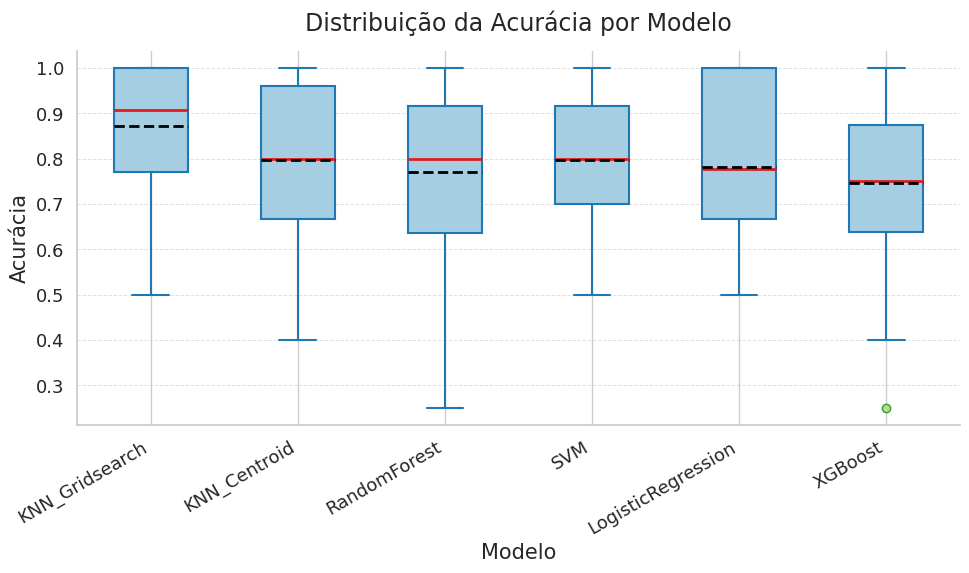

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que df_results já está carregado
modelos = df_results['model'].unique()
data = [df_results[df_results['model'] == m]['accuracy'].values for m in modelos]

plt.figure(figsize=(10, 6))

box = plt.boxplot(
    data,
    patch_artist=True,
    showmeans=True,
    meanline=True,
    boxprops=dict(facecolor='#a6cee3', color='#1f78b4', linewidth=1.5),
    medianprops=dict(color='#e31a1c', linewidth=2),
    meanprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='#1f78b4', linewidth=1.5),
    capprops=dict(color='#1f78b4', linewidth=1.5),
    flierprops=dict(marker='o', markerfacecolor='#b2df8a', markersize=6, linestyle='none', markeredgecolor='#33a02c')
)

plt.xticks(np.arange(1, len(modelos)+1), modelos, fontsize=13, rotation=30, ha='right')
plt.yticks(fontsize=13)
plt.ylabel('Acurácia', fontsize=15)
plt.xlabel('Modelo', fontsize=15)
plt.title('Distribuição da Acurácia por Modelo', fontsize=17, pad=15)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("boxplot_acuracia_modelos_matplotlib.png", dpi=300, bbox_inches='tight')
plt.show()

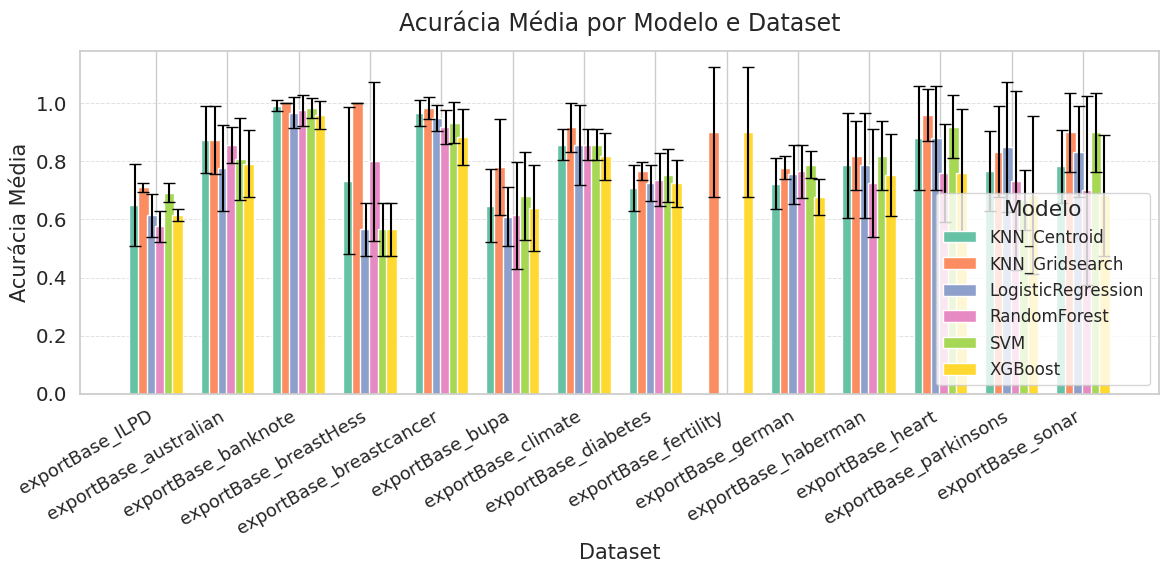

In [50]:
# ... existing code ...
import matplotlib.pyplot as plt
import numpy as np

# Calcula a média e o desvio padrão da acurácia por modelo e dataset
summary = (
    df_results
    .groupby(['dataset', 'model'])['accuracy']
    .agg(['mean', 'std'])
    .reset_index()
)

# Ordena os modelos para manter a ordem nos gráficos
modelos = summary['model'].unique()
datasets = summary['dataset'].unique()
x = np.arange(len(datasets))  # posição dos grupos (datasets)

bar_width = 0.15
offsets = np.linspace(-bar_width*2, bar_width*2, len(modelos))

plt.figure(figsize=(12, 6))

for i, model in enumerate(modelos):
    means = []
    stds = []
    for ds in datasets:
        row = summary[(summary['dataset'] == ds) & (summary['model'] == model)]
        means.append(row['mean'].values[0] if not row.empty else np.nan)
        stds.append(row['std'].values[0] if not row.empty else 0)
    plt.bar(x + offsets[i], means, bar_width, label=model, yerr=stds, capsize=4)

plt.xticks(x, datasets, fontsize=13, rotation=30, ha='right')
plt.ylabel('Acurácia Média', fontsize=15)
plt.xlabel('Dataset', fontsize=15)
plt.title('Acurácia Média por Modelo e Dataset', fontsize=17, pad=15)
plt.legend(title='Modelo', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.savefig("barras_acuracia_modelos.png", dpi=300, bbox_inches='tight')
plt.show()
# ... existing code ...

In [24]:
# Supondo que df_results já está carregado
# Calcula a acurácia média por dataset e modelo
pivot = (
    df_results
    .groupby(['dataset', 'model'])['accuracy']
    .mean()
    .unstack()  # linhas: datasets, colunas: modelos
)
pivot

model,KNN_Centroid,LogisticRegression,RandomForest,SVM,XGBoost
dataset,,,,,
adult_income,0.810983,0.845444,0.849004,0.839574,0.858158
bank_marketing,0.889593,0.899418,0.901188,0.896202,0.899782
default_of_credit_card_clients,0.670705,0.637634,0.692192,0.694314,0.685208
magic_gamma_telescope,0.842376,0.791167,0.881966,0.869664,0.881335
phishing_websites,0.946359,0.926640,0.971054,0.951606,0.971687


In [25]:
from scipy.stats import friedmanchisquare

# O teste espera cada modelo como um array (coluna)
stat, p = friedmanchisquare(*[pivot[model].values for model in pivot.columns])
print(f"Friedman statistic: {stat:.4f}, p-value: {p:.4f}")

if p < 0.05:
    print("Há diferença estatística significativa entre os modelos (p < 0.05).")
else:
    print("Não há diferença estatística significativa entre os modelos (p >= 0.05).")

Friedman statistic: 13.6000, p-value: 0.0087
Há diferença estatística significativa entre os modelos (p < 0.05).


In [33]:
import scikit_posthocs as sp

# ranks: matriz de ranks (datasets x modelos)
ranks = pivot.rank(axis=1, ascending=False, method='min')

nemenyi = sp.posthoc_nemenyi_friedman(pivot.values)
print("Matriz de p-valores do teste de Nemenyi:")
print(nemenyi)

Matriz de p-valores do teste de Nemenyi:
          0         1         2         3         4
0  1.000000  0.999644  0.040876  0.627659  0.070324
1  0.999644  1.000000  0.070324  0.751424  0.115233
2  0.040876  0.070324  1.000000  0.627659  0.999644
3  0.627659  0.751424  0.627659  1.000000  0.751424
4  0.070324  0.115233  0.999644  0.751424  1.000000


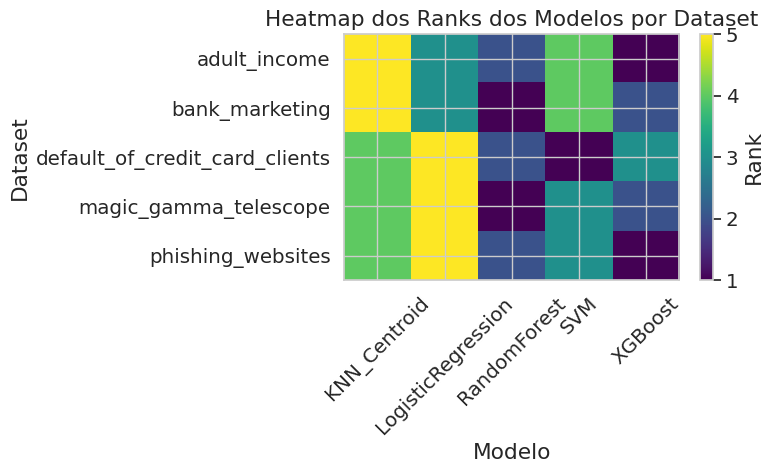

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.imshow(ranks, cmap='viridis', aspect='auto')
plt.colorbar(label='Rank')
plt.xticks(ticks=range(len(ranks.columns)), labels=ranks.columns, rotation=45)
plt.yticks(ticks=range(len(ranks.index)), labels=ranks.index)
plt.title('Heatmap dos Ranks dos Modelos por Dataset')
plt.xlabel('Modelo')
plt.ylabel('Dataset')
plt.tight_layout()
plt.show()

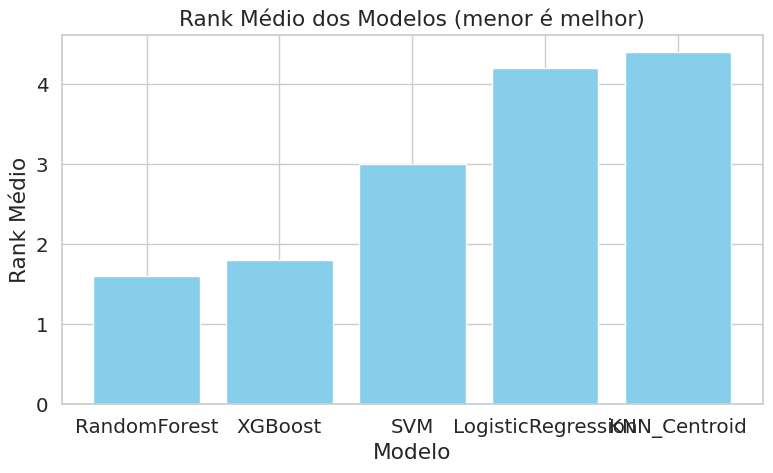

In [35]:
rank_medio = ranks.mean(axis=0).sort_values()
plt.figure(figsize=(8, 5))
plt.bar(rank_medio.index, rank_medio.values, color='skyblue')
plt.ylabel('Rank Médio')
plt.xlabel('Modelo')
plt.title('Rank Médio dos Modelos (menor é melhor)')
plt.tight_layout()
plt.show()

---

## Teste Bases pequenas

In [2]:
import os
import scipy.io
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

pasta = 'data/dados'
arquivos_mat = [f for f in os.listdir(pasta) if f.endswith('_1.mat')]
datasets_mat = {}

for arquivo in tqdm(arquivos_mat, desc="Carregando datasets"):
    mat_data = scipy.io.loadmat(os.path.join(pasta, arquivo))
    nome_dataset = '_'.join(arquivo.split('_')[:2])
    X, y = mat_data['data'][0][0][0], mat_data['data'][0][0][1]
    
    # Normaliza os dados (sem PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Garante que y seja 1D e valores sejam -1 ou 1
    y = y.flatten()
    y = np.where(y == 0, -1, y)  # Converter possíveis 0s para -1

    # Cria DataFrame igual aos outros datasets
    colunas = [f'feat_{i}' for i in range(X_scaled.shape[1])]
    df = pd.DataFrame(X_scaled, columns=colunas)
    df['target'] = y

    datasets_mat[nome_dataset] = df

Carregando datasets: 100%|██████████| 15/15 [00:00<00:00, 1205.38it/s]


In [5]:
import pandas as pd
from tqdm import tqdm

# Defina aqui a fração dos dados que deseja usar (ex: 1.0 para tudo, 0.2 para 20%)
frac = 1  # Altere para testar mais rápido

model_funcs = {
    "KNN_Gridsearch": evaluate_knn_centroid_distance_gridsearch_cv,
    "KNN_Centroid": evaluate_knn_centroid_distance,
    "RandomForest": evaluate_random_forest,
    "SVM": evaluate_svm,
    "LogisticRegression": evaluate_logistic_regression,
    "XGBoost": evaluate_xgboost,
}

all_results = []

for dataset_name, dataset_df in tqdm(datasets_mat.items(), desc="Datasets"):
    print(f"\n=== Rodando para dataset: {dataset_name} ===")
    for model_name, model_func in tqdm(model_funcs.items(), desc=f"Modelos ({dataset_name})", leave=False, position=1):
        print(f"  -> Rodando modelo: {model_name}")
        try:
            results = model_func(dataset_df, frac=frac)
            n_folds = len(results['accuracy'])
            for i in range(n_folds):
                all_results.append({
                    "dataset": dataset_name,
                    "model": model_name,
                    "run": i+1,
                    "accuracy": results['accuracy'][i],
                    "f1": results['f1'][i],
                    "roc_auc": results['roc_auc'][i],
                    "mcc": results['mcc'][i],
                    "train_time": results['train_time'][i],
                    "frac": frac,
                })
        except Exception as e:
            print(f"Erro inesperado para {model_name} em {dataset_name}: {e}")
            continue

df_results = pd.DataFrame(all_results)
df_results.to_csv("data/resultados_modelos_cv_mat_cv.csv", index=False)

Datasets:   0%|          | 0/15 [00:00<?, ?it/s]


=== Rodando para dataset: exportBase_climate ===


  -> Rodando modelo: KNN_Gridsearch


Datasets:   0%|          | 0/15 [08:23<?, ?it/s]


KeyboardInterrupt: 

In [3]:
df_results = pd.read_csv("data/resultados_modelos_cv_mat.csv")

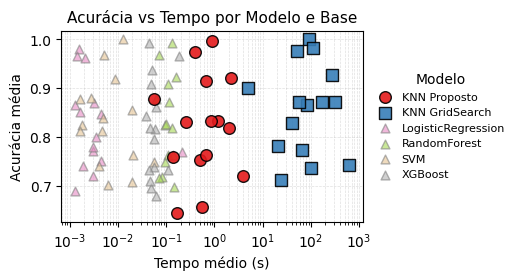

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Garante que a pasta existe
os.makedirs('imagens/artigo2', exist_ok=True)

# Escolha a métrica que deseja visualizar
metric = 'accuracy'  # ou 'f1' ou 'roc_auc'
metric_label = {'accuracy': 'Acurácia', 'f1': 'F1-score', 'roc_auc': 'AUC'}[metric]

# Calcule médias por modelo e dataset
grouped = df_results.groupby(['model', 'dataset']).agg(
    tempo_medio=('train_time', 'mean'),
    desempenho_medio=(metric, 'mean')
).reset_index()

# Paleta de cores para modelos
modelos = grouped['model'].unique()
cores = plt.cm.Set2(np.linspace(0, 1, len(modelos)))
cor_modelo = dict(zip(modelos, cores))

# Destaque para KNN proposto e GridSearch
destaques = {
    'KNN_Centroid': {'cor': '#e41a1c', 'marker': 'o', 'label': 'KNN Proposto', 'size': 70, 'zorder': 3},
    'KNN_Gridsearch': {'cor': '#377eb8', 'marker': 's', 'label': 'KNN GridSearch', 'size': 70, 'zorder': 3}
}

plt.figure(figsize=(5.2, 2.8))

# Para evitar repetição na legenda, vamos guardar handles
handles = []
labels = []

for modelo in modelos:
    dados = grouped[grouped['model'] == modelo]
    if modelo in destaques:
        sc = plt.scatter(
            dados['tempo_medio'], dados['desempenho_medio'],
            c=destaques[modelo]['cor'],
            marker=destaques[modelo]['marker'],
            s=destaques[modelo]['size'],
            label=destaques[modelo]['label'],
            edgecolor='black',
            zorder=destaques[modelo]['zorder'],
            alpha=0.9
        )
        handles.append(sc)
        labels.append(destaques[modelo]['label'])
    else:
        sc = plt.scatter(
            dados['tempo_medio'], dados['desempenho_medio'],
            c=[cor_modelo[modelo]],
            marker='^',
            s=40,
            label=modelo,
            alpha=0.6,
            edgecolor='gray',
            zorder=2
        )
        handles.append(sc)
        labels.append(modelo)

plt.xscale('log')
plt.xlabel('Tempo médio (s)', fontsize=10)
plt.ylabel(f'{metric_label} média', fontsize=10)
plt.title(f'{metric_label} vs Tempo por Modelo e Base', fontsize=11, pad=6)

# Legenda fora do gráfico, à direita, sem repetição
plt.legend(handles, labels, fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, handlelength=1.5, title='Modelo')

plt.grid(True, which="both", ls="--", alpha=0.4, linewidth=0.5)
plt.tight_layout(pad=0.7)
plt.savefig(f'imagens/artigo2/scatter_{metric}_tempo.png', dpi=600, bbox_inches='tight')
plt.show()

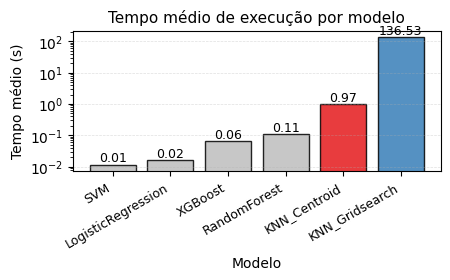

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Garante que a pasta existe
os.makedirs('imagens/artigo2', exist_ok=True)

# Calcule o tempo médio de execução por modelo
tempos = df_results.groupby('model')['train_time'].mean().sort_values()
modelos = tempos.index.tolist()
valores = tempos.values

# Cores: destaque para KNN_Centroid e KNN_Gridsearch
cores = []
for modelo in modelos:
    if modelo == 'KNN_Centroid':
        cores.append('#e41a1c')  # vermelho forte
    elif modelo == 'KNN_Gridsearch':
        cores.append('#377eb8')  # azul forte
    else:
        cores.append('#bdbdbd')  # cinza claro

# Tamanho ajustado para artigo (largura proporcional ao número de modelos)
largura = max(4.5, 0.6 * len(modelos))
plt.figure(figsize=(largura, 2.8))  # polegadas

barras = plt.bar(modelos, valores, color=cores, edgecolor='black', alpha=0.85)

# Adiciona rótulos de tempo acima das barras
for bar, tempo in zip(barras, valores):
    plt.text(bar.get_x() + bar.get_width()/2, tempo, f"{tempo:.2f}", ha='center', va='bottom', fontsize=9)

plt.yscale('log')
plt.ylabel('Tempo médio (s)', fontsize=10)
plt.xlabel('Modelo', fontsize=10)
plt.title('Tempo médio de execução por modelo', fontsize=11, pad=6)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.4, linewidth=0.5)
plt.tight_layout(pad=0.7)
plt.savefig('imagens/artigo2/barplot_tempo_medio_modelos.png', dpi=600, bbox_inches='tight')
plt.show()

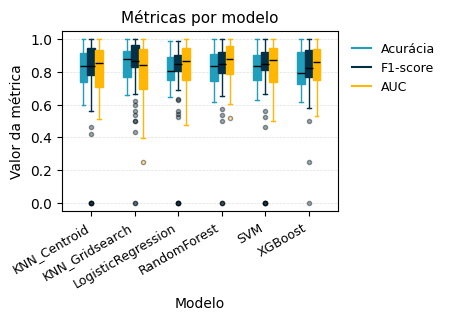

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Garante que a pasta existe
os.makedirs('imagens/artigo2', exist_ok=True)

metrics = ['accuracy', 'f1', 'roc_auc']
metric_names = ['Acurácia', 'F1-score', 'AUC']
models = np.sort(df_results['model'].unique())  # ordem alfabética

# Preparar os dados para cada métrica e modelo
data = []
for metric in metrics:
    data.append([df_results[df_results['model'] == model][metric].values for model in models])

# Tamanho ajustado para evitar sobreposição (bom para artigo e visualização)
largura = max(4.5, 0.6 * len(models))  # aumenta largura se muitos modelos
plt.figure(figsize=(largura, 3.2))  # polegadas

box_width = 0.18
positions = np.arange(len(models))

# Cores para cada métrica (paleta elegante)
colors = ["#219ebc", "#023047", "#ffb703"]

for i, (metric_data, color, name) in enumerate(zip(data, colors, metric_names)):
    pos = positions + (i - 1) * box_width
    bp = plt.boxplot(metric_data, positions=pos, widths=box_width, patch_artist=True,
                     boxprops=dict(facecolor=color, color=color),
                     medianprops=dict(color='black'),
                     whiskerprops=dict(color=color),
                     capprops=dict(color=color),
                     flierprops=dict(markerfacecolor=color, marker='o', markersize=3, alpha=0.4))

plt.xticks(positions, models, rotation=30, ha='right', fontsize=9)
plt.xlabel('Modelo', fontsize=10)
plt.ylabel('Valor da métrica', fontsize=10)
plt.title('Métricas por modelo', fontsize=11, pad=6)

# Legenda compacta, fora do gráfico se couber
for i, name in enumerate(metric_names):
    plt.plot([], c=colors[i], label=name)
plt.legend(fontsize=9, loc='upper left', frameon=False, handlelength=1.5, bbox_to_anchor=(1.01, 1))

plt.grid(axis='y', linestyle='--', alpha=0.4, linewidth=0.5)
plt.tight_layout(pad=0.7)
plt.savefig('imagens/artigo2/boxplot_metricas_modelos.png', dpi=600, bbox_inches='tight')
plt.show()

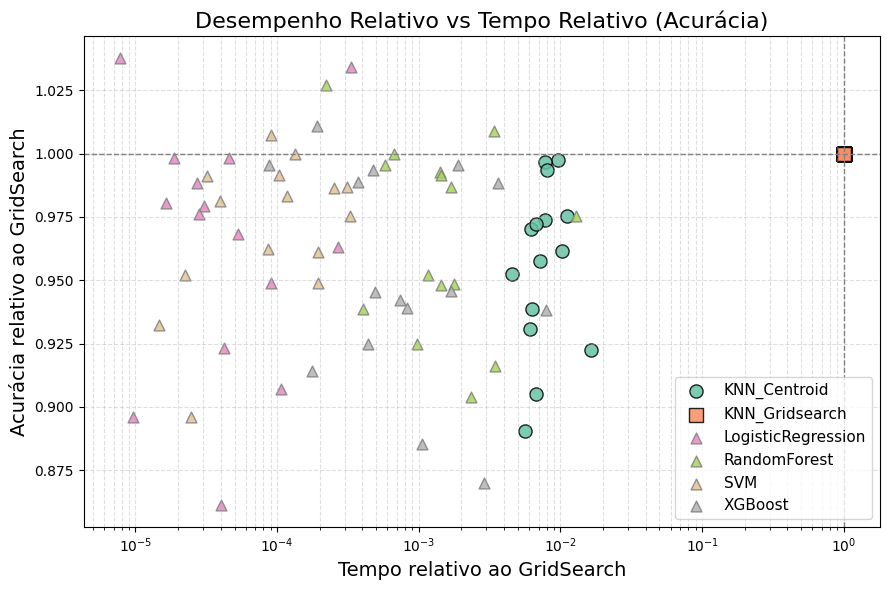

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Escolha a métrica de desempenho
metric = 'accuracy'  # ou 'f1' ou 'roc_auc'
metric_label = {'accuracy': 'Acurácia', 'f1': 'F1-score', 'roc_auc': 'AUC'}[metric]

# Calcule médias por modelo e dataset
grouped = df_results.groupby(['dataset', 'model']).agg(
    tempo_medio=('train_time', 'mean'),
    desempenho_medio=(metric, 'mean')
).reset_index()

# Pegue os valores do GridSearch para cada dataset
gridsearch = grouped[grouped['model'] == 'KNN_Gridsearch'][['dataset', 'tempo_medio', 'desempenho_medio']]
gridsearch = gridsearch.rename(columns={'tempo_medio': 'tempo_gs', 'desempenho_medio': 'desempenho_gs'})

# Junte para calcular as razões
merged = grouped.merge(gridsearch, on='dataset', how='left')
merged['tempo_rel'] = merged['tempo_medio'] / merged['tempo_gs']
merged['desempenho_rel'] = merged['desempenho_medio'] / merged['desempenho_gs']

# Paleta de cores para modelos
modelos = merged['model'].unique()
cores = plt.cm.Set2(np.linspace(0, 1, len(modelos)))
cor_modelo = dict(zip(modelos, cores))

plt.figure(figsize=(9, 6))

for modelo in modelos:
    dados = merged[merged['model'] == modelo]
    plt.scatter(
        dados['tempo_rel'], dados['desempenho_rel'],
        c=[cor_modelo[modelo]],
        label=modelo,
        s=90 if modelo in ['KNN_Centroid', 'KNN_Gridsearch'] else 60,
        marker='o' if modelo == 'KNN_Centroid' else ('s' if modelo == 'KNN_Gridsearch' else '^'),
        edgecolor='black' if modelo in ['KNN_Centroid', 'KNN_Gridsearch'] else 'gray',
        alpha=0.85
    )

plt.axhline(1, color='gray', linestyle='--', linewidth=1)
plt.axvline(1, color='gray', linestyle='--', linewidth=1)
plt.xscale('log')
plt.xlabel('Tempo relativo ao GridSearch', fontsize=14)
plt.ylabel(f'{metric_label} relativo ao GridSearch', fontsize=14)
plt.title(f'Desempenho Relativo vs Tempo Relativo ({metric_label})', fontsize=16)
plt.legend(fontsize=11)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.savefig(f'scatter_relativo_{metric}.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
import pandas as pd

# Calcule a média da métrica para cada modelo em cada dataset
pivot = df_results.pivot_table(index='dataset', columns='model', values='accuracy', aggfunc='mean')

In [15]:
# Rank: 1 = melhor (maior valor)
ranks = pivot.rank(axis=1, ascending=False, method='min')

In [16]:
from scipy.stats import friedmanchisquare

# O teste espera cada modelo como uma coluna (cada linha = dataset)
friedman_stat, friedman_p = friedmanchisquare(*[ranks[model] for model in ranks.columns])
print(f"Estatística de Friedman: {friedman_stat:.3f}, p-valor: {friedman_p:.4f}")
if friedman_p < 0.05:
    print("Há diferença significativa entre os modelos (p < 0.05).")
else:
    print("Não há diferença significativa entre os modelos (p >= 0.05).")

Estatística de Friedman: 27.137, p-valor: 0.0001
Há diferença significativa entre os modelos (p < 0.05).


In [18]:
import scikit_posthocs as sp

nemenyi = sp.posthoc_nemenyi_friedman(ranks.values)
nemenyi.index = ranks.columns
nemenyi.columns = ranks.columns

In [19]:
from scipy.stats import friedmanchisquare

# Calcule a matriz de ranks (1 = melhor)
pivot = df_results.pivot_table(index='dataset', columns='model', values='accuracy', aggfunc='mean')
ranks = pivot.rank(axis=1, ascending=False, method='min')

# Teste de Friedman
friedman_stat, friedman_p = friedmanchisquare(*[ranks[model] for model in ranks.columns])
print(f"Estatística de Friedman: {friedman_stat:.3f}, p-valor: {friedman_p:.4f}")

Estatística de Friedman: 27.137, p-valor: 0.0001


In [37]:
rank_means.to_clipboard()

In [20]:
# Ranks médios
rank_means = ranks.mean(axis=0).sort_values()
print("Ranks médios dos modelos:")
print(rank_means)

Ranks médios dos modelos:
model
KNN_Gridsearch        1.400000
RandomForest          3.333333
SVM                   3.400000
KNN_Centroid          3.800000
LogisticRegression    3.800000
XGBoost               4.733333
dtype: float64


/tmp/ipykernel_57248/1524698195.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGnBu_r')


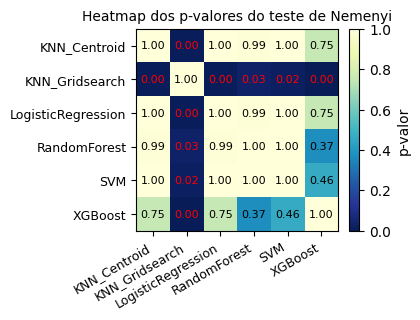

In [39]:
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import numpy as np
import os

# Garante que a pasta existe
os.makedirs('imagens/artigo2', exist_ok=True)

# Teste de Nemenyi
nemenyi = sp.posthoc_nemenyi_friedman(ranks.values)
nemenyi.index = ranks.columns
nemenyi.columns = ranks.columns

# Paleta de cores elegante: azul (baixo) -> branco -> amarelo (alto)
cmap = plt.cm.get_cmap('YlGnBu_r')

# Tamanho ajustado para artigo
plt.figure(figsize=(4.2, 3.2))

im = plt.imshow(nemenyi.values, cmap=cmap, vmin=0, vmax=1)
plt.colorbar(im, label='p-valor', fraction=0.046, pad=0.04)
plt.xticks(np.arange(len(nemenyi.columns)), nemenyi.columns, rotation=30, ha='right', fontsize=9)
plt.yticks(np.arange(len(nemenyi.index)), nemenyi.index, fontsize=9)
plt.title('Heatmap dos p-valores do teste de Nemenyi', fontsize=10, pad=6)

# Destaca p < 0.05
for i in range(len(nemenyi.index)):
    for j in range(len(nemenyi.columns)):
        valor = nemenyi.values[i, j]
        cor = 'red' if valor < 0.05 and i != j else 'black'
        plt.text(j, i, f"{valor:.2f}", ha='center', va='center', color=cor, fontsize=8)

plt.tight_layout(pad=0.7)
plt.savefig('imagens/artigo2/heatmap_nemenyi.png', dpi=600, bbox_inches='tight')
plt.show()

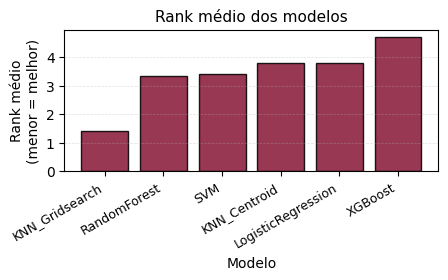

In [38]:
import matplotlib.pyplot as plt
import os

# Garante que a pasta existe
os.makedirs('imagens/artigo2', exist_ok=True)

# Cor vinho elegante (exemplo: '#8B1C3B')
cor_vinho = '#8B1C3B'

# Tamanho ajustado para artigo
largura = max(4.5, 0.6 * len(rank_means))
plt.figure(figsize=(largura, 2.8))

plt.bar(rank_means.index, rank_means.values, color=cor_vinho, edgecolor='black', alpha=0.88)

plt.ylabel('Rank médio\n(menor = melhor)', fontsize=10)
plt.xlabel('Modelo', fontsize=10)
plt.title('Rank médio dos modelos', fontsize=11, pad=6)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.4, linewidth=0.5)
plt.tight_layout(pad=0.7)
plt.savefig('imagens/artigo2/barplot_ranks_medios.png', dpi=600, bbox_inches='tight')
plt.show()

In [25]:
# Calcula a média de cada métrica para cada modelo
tabela_resumo = df_results.groupby('model')[['accuracy', 'f1', 'roc_auc', 'mcc', 'train_time']].mean()

# Opcional: arredonda para 3 casas decimais para facilitar a leitura
tabela_resumo = tabela_resumo.round(3)

In [27]:
tabela_resumo.to_clipboard()